In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


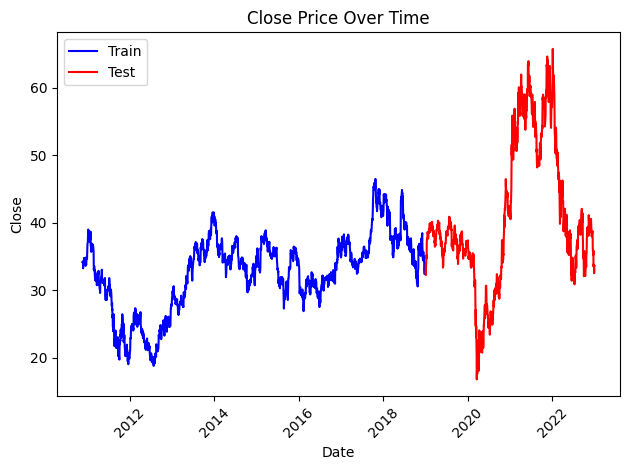

In [2]:
#AAPL
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
data = Data('GM',start_date,end_date,period,2019)
data.data_preprocess()

In [3]:
ga = IslandGGA(data=data.train_data,pSize=100,strategies=data.top_strategy_names,evolve_strategy="ring")
ga.evolve()

Running ring
Generation 1: Best fitness = 1.6868457600974311 Average Fitness = 0.6620009400958555
Generation 2: Best fitness = 1.6868457600974311 Average Fitness = 0.7818947396072824
Generation 3: Best fitness = 1.6868457600974311 Average Fitness = 0.8788197582951962
Generation 4: Best fitness = 1.6868457600974311 Average Fitness = 0.950448215894842
Generation 5: Best fitness = 1.7040648663325713 Average Fitness = 0.9737548902670836
Generation 6: Best fitness = 1.7040648663325713 Average Fitness = 1.002262279669995
Generation 7: Best fitness = 1.7040648663325713 Average Fitness = 1.0284358284003023
Generation 8: Best fitness = 1.7040648663325713 Average Fitness = 1.0370489846712456
Generation 9: Best fitness = 1.830342566484648 Average Fitness = 1.06257501452065
Generation 10: Best fitness = 1.9024762770604264 Average Fitness = 1.082878762647907
Island 0 Migration -Left island 9 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right i

In [3]:
data.data_period = "train"
print("Train period:")
data.comparison_metrics()
data.buy_and_hold()
print("======")
data.data_period = "test"
print("Test period:")
data.comparison_metrics()
data.buy_and_hold()

Train period:
Return: 0.25482478294066824
Portfolio MDD: 0.4296598294757559
Portfolio Std Dev: 0.07668105104126983
Test period:
Return: 0.08102175188235927
Portfolio MDD: 0.7504753700331097
Portfolio Std Dev: 0.1419576206685815


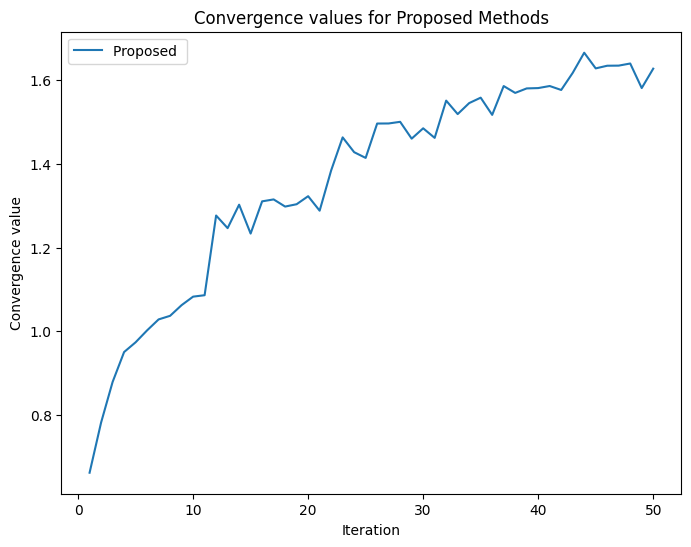

In [4]:
# Plot the convergence values for each evolutionary strategy
plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, 51), ga.convergence_values, label='Proposed ')
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for Proposed Methods')
plt.legend()
plt.show()

In [ ]:
b = ga.globalBest

In [ ]:
import numpy as np
import pandas as pd

# Monthly returns DataFrame for each asset
monthly_returns = data.strategy_performance()
cumulative_returns = (1 + monthly_returns).cumprod()

# Calculate portfolio performance
# Calculate mean cumulative returns
mean_cumulative_returns = cumulative_returns.mean(axis=1)
# Calculate portfolio performance at the end of the period
portfolio_return = mean_cumulative_returns.iloc[-1]-1
# MDD
cumulative_max = cumulative_returns.cummax()
drawdown = cumulative_max - cumulative_returns
max_drawdown = drawdown.max()

# Calculate mean Maximum Drawdown (MDD) for all groups
porfolio_mdd = np.mean(max_drawdown)


num_groups = len(data.strategies) # Number of groups
# Calculate equal weights for each group
equal_weights = 1 / num_groups
# Create an array of equal weights for each group
weights= np.full(num_groups, equal_weights)
covariance_matrix = monthly_returns.cov()
portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
portfolio_std_dev = np.sqrt(portfolio_variance)

portfolio_return,porfolio_mdd, portfolio_std_dev,

In [ ]:
# Monthly returns DataFrame for each asset
monthly_returns = strategy_performance(data)

# Calculate cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod()

# Calculate mean cumulative returns
mean_cumulative_returns = cumulative_returns.mean(axis=1)

# Calculate portfolio performance at the end of the period
portfolio_return = mean_cumulative_returns.iloc[-1]-1
portfolio_return

In [ ]:
import numpy as np
import pandas as pd


def strategy_performance(data):
    strategy_performance = {}
    for strategy in b.strategies:
        strategy_performance[strategy] =  b.generate_trading_signal(data,strategy,-1,1)
    strategy_performance = pd.DataFrame.from_dict(strategy_performance)
    return strategy_performance
# Monthly returns DataFrame for each asset
monthly_returns = strategy_performance(data.train_data)


# Calculate Maximum Drawdown (MDD) for all strategies


group_returns = monthly_returns
cumulative_returns = (1 + group_returns).cumprod()
cumulative_max = cumulative_returns.cummax()
drawdown = cumulative_max - cumulative_returns
max_drawdown = drawdown.max()

# Calculate mean Maximum Drawdown (MDD) for all groups
mean_mdd = np.mean(max_drawdown)

mean_mdd

In [ ]:


# Monthly returns for each strategy
monthly_returns = data.strategy_performance()


# Determine the grid dimensions
num_strategies = len(monthly_returns.columns)
grid_rows = int(num_strategies / 2)  # Number of rows in the grid
grid_cols = 2  # Number of columns in the grid

# Adjust the figure size based on the number of subplots
fig_width = 12
fig_height = 4 * grid_rows

# Create the subplots with the specified grid dimensions and figure size
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(fig_width, fig_height))

# Flatten the axes array if necessary
if grid_rows > 1:
    axes = axes.flatten()

# Iterate over each strategy and plot its cumulative profits
for idx, (strategy, returns) in enumerate(monthly_returns.iteritems()):
    cumulative_profits = np.cumprod(1 + returns)-1  # Calculate cumulative profits
    ax = axes[idx] if grid_rows > 1 else axes  # Select the correct subplot
    ax.plot(cumulative_profits)
    ax.set_xlabel('Month')
    ax.set_ylabel('Cumulative Profit')
    ax.set_title(f'Cumulative Profits for {strategy}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()




In [ ]:
asset_prices = data.train_data.copy()
# Set the 'Date' column as the index of the DataFrame if it's not already
asset_prices.set_index('Date', inplace=True)

# Resample the asset prices to monthly frequency and select the first and last values of each month
monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

# Calculate the monthly returns as the percentage change in price
monthly_returns = monthly_prices['close', 'last'].pct_change()

# Calculate the cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod()

# Calculate the profit as the difference between the final cumulative return and 1 (initial investment)
profit = cumulative_returns.iloc[-1]-1

print("Profit for the Buy-and-Hold Strategy:")



In [ ]:

def max_drawdown(returns):
  """
  Calculates the maximum drawdown from monthly returns.

  Args:
    returns: A pandas DataFrame of monthly returns.

  Returns:
    The maximum drawdown.
  """

  # Calculate the cumulative returns.
  cumulative_returns = (1 + returns).cumprod()

  # Find the minimum value of the cumulative returns.
  min_return = cumulative_returns.min()

  # Calculate the maximum drawdown.
  max_drawdown = (1 - min_return) 

  return max_drawdown

if __name__ == "__main__":
  # Load the monthly returns data.

  asset_prices = data.train_data.copy()
  # Set the 'Date' column as the index of the DataFrame if it's not already
  asset_prices.set_index('Date', inplace=True)

  # Resample the asset prices to monthly frequency and select the first and last values of each month
  monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

  # Calculate the monthly returns as the percentage change in price
  monthly_returns = monthly_prices['close', 'last'].pct_change()

  # Calculate the maximum drawdown.

  # Calculate the cumulative returns
  cumulative_returns = (1 + monthly_returns).cumprod()
  # Calculate the profit as the difference between the final cumulative return and 1 (initial investment)
  profit = cumulative_returns.iloc[-1]-1

  # Find the minimum value of the cumulative returns.
  min_return = cumulative_returns.min()

  # Calculate the maximum drawdown.
  max_drawdown = (1 - min_return) 

  max_drawdown = max_drawdown(monthly_returns)

  # Print the maximum drawdown.
  print(f"Buy and Hold mdd is {max_drawdown:.2f}.")
  print(f"Profit for the Buy and Hold Strategy: {profit:.2f}.")

